In [27]:
import numpy as np
from matplotlib import pyplot as plt, cm
from numba import jit, cuda
from IPython.display import clear_output
%matplotlib inline

In [28]:
@jit(nopython=True)
def init(nx, ny):
    cx = np.array([0, 1, 0, -1, 0, 1, -1, -1, 1])
    cy = np.array([0, 0, 1, 0, -1, 1, 1, -1, -1])
    wt = np.array([4/9, 1/9, 1/9, 1/9, 1/9, 1/36, 1/36, 1/36, 1/36])
    f = np.zeros((ny, nx, 9))
    ft = np.zeros((ny, nx, 9)) ##temporary storage
    for i in range(nx):
        for j in range(ny):
            for a in range(len(wt)):
                f[j, i, a] = wt[a]
    return cx, cy, wt, f, ft

In [29]:
cx, cy, wt, f, ft = init(10, 10)## random test run

In [30]:
np.sum(wt)

1.0

In [31]:
@jit(nopython=True)
def presgrad(Re, nu, H):
    ## calculate pressure gradient to maintain the the specified Re number
    u_max_theoretical = Re * nu / H * 1.5 # for parabolic flow
    dpdx = 8 * nu * u_max_theoretical / (H**2)
    
    return dpdx

In [32]:
presgrad(1, 0.0001, 19)## random test run

1.7495261699956262e-11

In [33]:
@jit(nopython=True)
def L2norm(u, u_old):
    C = np.sum(np.square(u - u_old)) / np.sum(np.square(u))
    l2 = np.sqrt(C)
    
    return l2

In [34]:
L2norm(cy, wt)## random test run

1.0206207261596574

In [35]:
@jit(nopython=True)
def oppoV(cx, cy):
    ## generate array containg direction opposite to index
    n = len(cx)
    opV = np.zeros(n, dtype = np.int32) ## 
    for a in range(n):
        for a1 in range(a, n):
            if((cx[a] + cx[a1]) == 0) and ((cy[a] + cy[a1]) == 0):
                opV[a]  = a1
                opV[a1] = a
                
    return opV

In [36]:
oppoV(cx, cy)## random test run

array([0, 3, 4, 1, 2, 7, 8, 5, 6])

In [37]:
np.shape(f)

(10, 10, 9)

In [38]:
@jit(nopython = True)
def analytical(delta, H, dpdx, visc, ny):
    ux = np.zeros(ny)

    for i in range(ny):
        y = (i - delta ) / H
        #print(y)
        ux[i] = 0.5 * dpdx * H**2 * (y - y**2) / visc

        if(i ==0 or i == (ny-1)):
            ux[i] = 0
            
    return ux
    

In [39]:
@jit(nopython=True)
def collision(dpdx, tau, nx, ny, f, ft, wt, cx, cy, u, v):
    #rho_avg = 0
    latcount = 0
    u[:] = 0
    v[:] = 0
    for i in range(nx):
        for j in range(1,ny):
            rho = 0
            for a in range(9):
                rho += f[j,i,a]
                u[j,i] += f[j,i,a] * cx[a]
                v[j,i] += f[j,i,a] * cy[a]
            
            #rho_avg += rho
            latcount += 1
            u[j,i] += dpdx/2
            u[j,i] /= rho
            v[j,i] /= rho
            u_mag2 = u[j,i]**2 + v[j,i]**2
            
            for a in range(9):
                t1 = u[j,i] * cx[a] + v[j,i] * cy[a]
                t2 = t1**2
                source = ((1 - 0.5 / tau) * wt[a] * dpdx * 
                          (3 *(cx[a] - u[j,i]) + 
                           9 * cx[a] * (cx[a] * u[j,i] + cy[a] * v[j,i])) )
                feq = wt[a] * rho * (1 + 3 * t1 + 4.5 * t2 - 1.5 * u_mag2)
                ft[j,i,a] = f[j,i,a] - (f[j,i,a] - feq) / tau + source
            
    return ft, u, v

In [40]:
@jit(nopython=True)
def streambb(nx, ny, cx, cy, opV, f, ft):
    ## streaming
    for i in range(nx):
        for j in range(1, ny-1):
            for a in range(9):
                ## get streamed directions
                istr = i + cx[a]
                if istr > (nx-1):  # takes care of periodic boundary condition
                    istr = 0       # since a -1 index defaults to the last item no need for 
                                   # adding condition to correct it to nx-1 
                jstr = j + cy[a]
                        
                f[jstr,istr,a] = ft[j,i,a]
                
    
    ## apply boundary conditions
    for j in [1, ny-2]:
        for i in range(nx):
            for a in range(9):
                istr = i - cx[a]
                if istr > (nx-1):
                    istr = 0
                jstr = j - cy[a]
                
                if (jstr == 0) or (jstr == ny-1):
                    f[j,i,a] = f[jstr,istr,opV[a]]
                
    return f
                

In [41]:
def LBsolve(nx, ny, tau, L2normTarget):
    #L2normTarget = 1e-6
    delta = 0.5
    Re = 1
    nu = (tau - 0.5) / 3
    H = ny - 1 - 2 * delta
    
    dpdx = presgrad(Re, nu, H)
    
    ## initialize
    cx, cy, wt, f, ft = init(nx, ny)
    opV = oppoV(cx, cy)
    
    u = np.zeros((ny,nx))
    un = np.zeros((ny,nx))
    v = np.zeros((ny,nx))
    vn = np.zeros((ny,nx))
    
    stepcount = 0
    L2nrm = 1
    
    while(L2nrm > L2normTarget):
        ##Calculate  Velocity and rho, and perform collision
        un = u.copy()
        vn = v.copy()
        ft, u, v = collision(dpdx, tau, nx, ny, f, ft, wt, cx, cy, u, v)
        f = streambb(nx, ny, cx, cy, opV, f, ft)
        
        L2nrm = L2norm(u, un)
        
        stepcount += 1
        if stepcount%20 == 0:
            A = np.max(u)
            clear_output(wait=True)
            print(stepcount, L2nrm, A, flush=True)
    u_th = analytical(delta, H, dpdx, nu, ny)  ## the analytical solution
    errornorm = L2norm(u[1:-1,-1],u_th[1:-1])
    
    print("Pressure grad = ", dpdx,"\n","H = ", H, "\n", "nu = ", nu,"\n")
    print("Error norm to analytical solution = ", errornorm)
    return u, v, u_th, errornorm

In [42]:
err = np.zeros(5)

Pressure grad =  2.0229606028422603e-06 
 H =  39.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  135.3901866234969
Wall time: 1.81 s


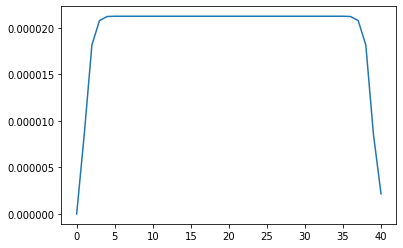

In [43]:
## dry run to force compilation
%time u, v, u_th, errtest = LBsolve(21, 41, 0.8, 1e-1)
plt.plot(u[:, -1])

3720 1.0350200723012852e-07 0.007883057678878683
Pressure grad =  1.7495261699956266e-05 
 H =  19.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.0020089342206695325
Wall time: 590 ms


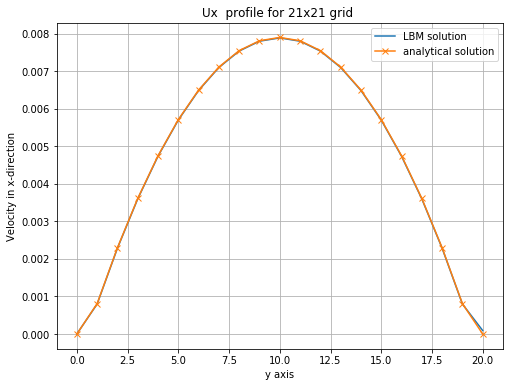

In [44]:
%time u, v, u_th, err[0] = LBsolve(21, 21, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x21 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

13520 1.0022618759215753e-07 0.003844226137050289
Pressure grad =  2.0229606028422603e-06 
 H =  39.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.0006107344740883937
Wall time: 2.53 s


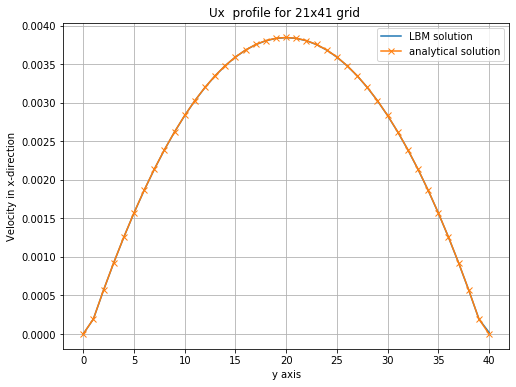

In [45]:
%time u, v, u_th, err[1] = LBsolve(21, 41, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x41 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

28020 1.0043207892911395e-07 0.0025410637691225175
Pressure grad =  5.842856377721191e-07 
 H =  59.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.0005441295707899156
Wall time: 6.52 s


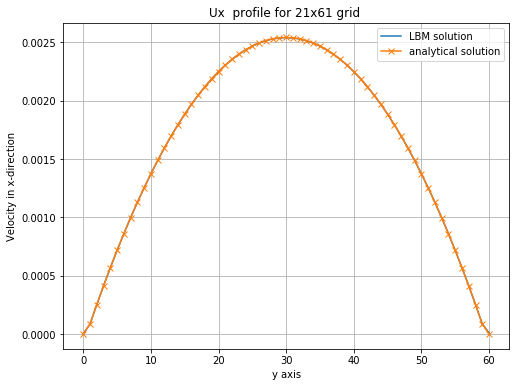

In [46]:
%time u, v, u_th, err[2] = LBsolve(21, 61, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x61 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

46560 1.0025474940248795e-07 0.001897333902866195
Pressure grad =  2.43388454057387e-07 
 H =  79.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.0007366269069322647
Wall time: 11.9 s


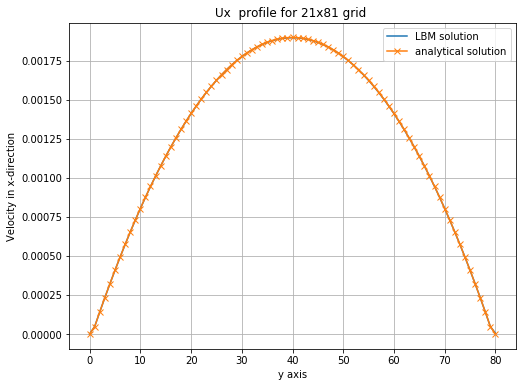

In [47]:
%time u, v, u_th, err[3] = LBsolve(21, 81, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x81 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

68660 1.0007240086921959e-07 0.0015135178452389245
Pressure grad =  1.236732182554038e-07 
 H =  99.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.0010588162611742918
Wall time: 21.1 s


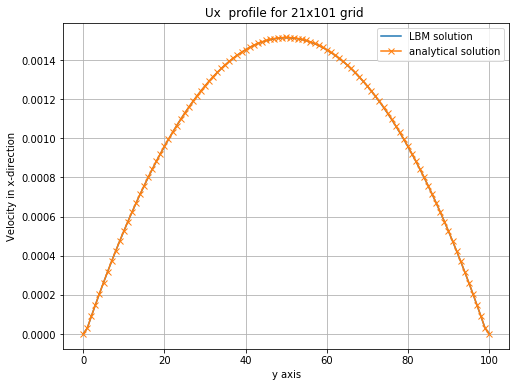

In [48]:
%time u, v, u_th, err[4] = LBsolve(21, 101, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x101 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

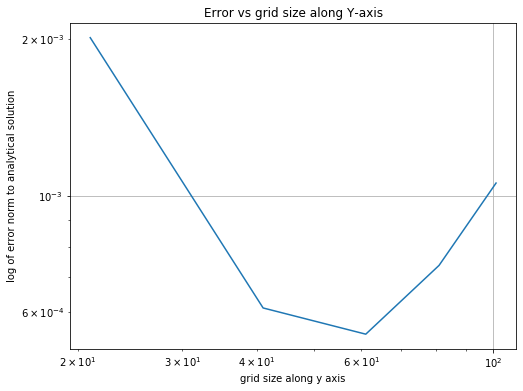

In [49]:
## ploting the variation of error norm with change in grid size
grids = np.array([21, 41, 61, 81, 101])
fig = plt.figure(figsize = (8,6))
plt.ylabel("log of error norm to analytical solution")
plt.xlabel("grid size along y axis")

plt.title("Error vs grid size along Y-axis")
plt.grid()
plt.loglog(grids, err)

In [50]:
## finding order of the scheme
parr = np.zeros(4)
## between 81 and 101
parr[0] = (np.log(err[4]) - np.log(err[3])) / (np.log(101) - np.log(81))

## between 61 and 81
parr[1] = (np.log(err[3]) - np.log(err[2])) / (np.log(81) - np.log(61))

## between 41 and 61
parr[2] = (np.log(err[2]) - np.log(err[1])) / (np.log(61) - np.log(41))

## between 21 and 41
parr[3] = (np.log(err[1]) - np.log(err[0])) / (np.log(41) - np.log(21))

P = np.average(parr)
P

0.16049549355625065

934460 1.0000308425879514e-07 0.00029296039362075414
Pressure grad =  9.657831170310471e-10 
 H =  499.0 
 nu =  0.10000000000000002 

Error norm to analytical solution =  0.02523157174759615
Wall time: 19min 18s


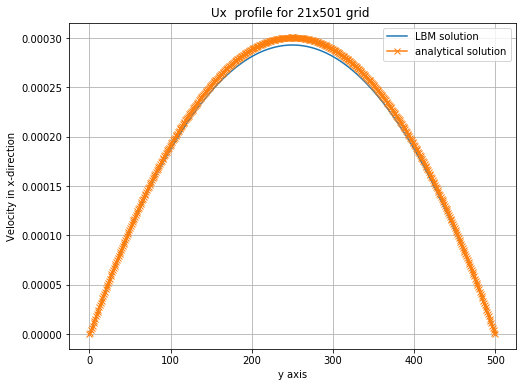

In [25]:
%time u, v, u_th, err = LBsolve(21, 501, 0.8, 1e-7)
fig = plt.figure(figsize = (8,6))
plt.ylabel("Velocity in x-direction")
plt.xlabel("y axis")

plt.title("Ux  profile for 21x501 grid ")
plt.grid() 
plt.plot(u[:, -1],label = "LBM solution" )
plt.plot(u_th, marker = "x", label="analytical solution")
plt.legend()

In [26]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce 940MX'                              [SUPPORTED]
                      compute capability: 5.0
                           pci device id: 0
                              pci bus id: 1
Summary:
	1/1 devices are supported


True